In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import warnings

rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

data_dir = Path('../BaekMinJae/')
trn_file = data_dir / 'train.csv'
seed = 42

trn = pd.read_csv(trn_file, index_col=0)
print(trn.shape)
trn.head()

(320000, 19)


,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,class
id,,,,,,,,,,,,,,,,,,,
0,23.2640,20.3368,19.0095,17.6724,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,18,18,1.1898,1.1907,1.1890,1.1894,1.1902,0
1,15.0521,14.0620,13.4524,13.2684,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,1,1,1.2533,1.2578,1.2488,1.2510,1.2555,1
2,16.7864,15.8254,15.5363,15.3935,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,2,2,1.0225,1.0241,1.0210,1.0217,1.0233,0
3,25.6606,21.1887,20.2212,19.8949,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,4,3,1.2054,1.2061,1.2049,1.2051,1.2057,0
4,24.4534,20.6992,19.0424,18.3242,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,13,12,1.1939,1.1943,1.1937,1.1938,1.1941,0


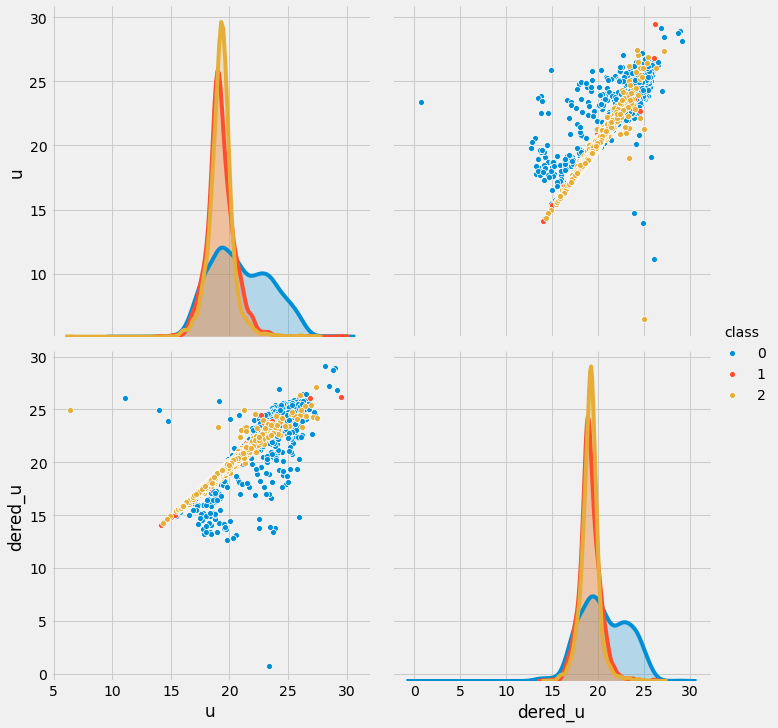

In [2]:
sns.pairplot(trn.sample(n=10000), vars=['u', 'dered_u'], 
hue = 'class', size=5)

In [3]:
print(trn.shape)

(320000, 19)


In [8]:
X = trn[trn['class'] != 0][['u']].values
y = trn[trn['class'] != 0]['dered_u'].values
print(X.shape, y.shape)

(200004, 1) (200004,)


In [5]:
rmse = lambda y, p: np.sqrt(np.mean((y - p) ** 2))

In [6]:
alpha = .001
theta0 = .1
theta1 = .1
epoch = 4

x = X.flatten()
print(x.shape)

(200004,)


In [9]:
rmses = []
for i in tqdm(range(epoch)):
    for x_i, y_i in zip(x,y):
        p_i = theta0 + theta1 * x_i
        theta0 = theta0 + alpha * (y_i - p_i)
        theta1 = theta1 + alpha * (y_i - p_i) * x_i
    rmses.append(rmse(y, theta0 + theta1 * x))

In [10]:
theta1, theta0

(0.9362306162023849, 1.1088813148478316)

In [11]:
rmses

[0.25618215910731906,
 0.25492967552380746,
 0.25461791287963526,
 0.25454708923095914]

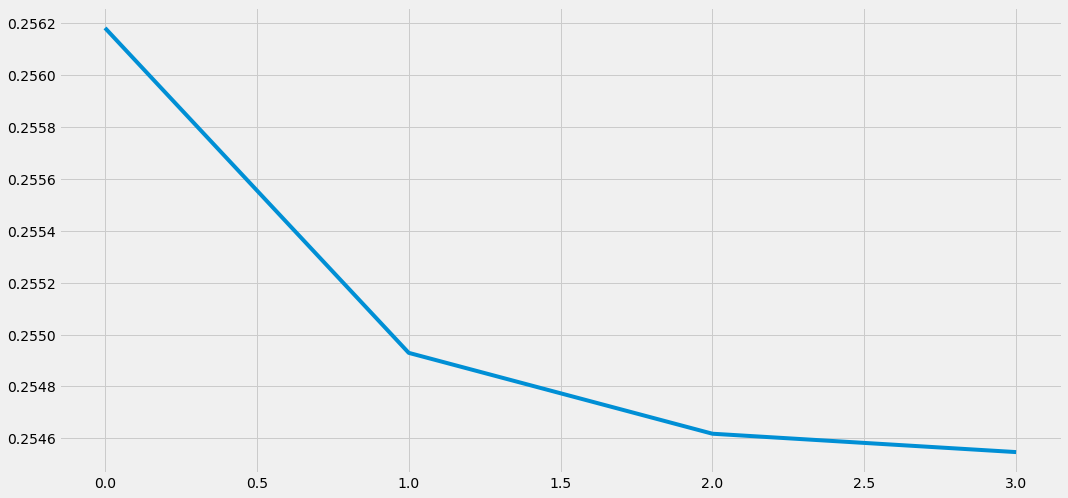

In [12]:
plt.plot(rmses)

Text(0, 0.5, 'dered_u')

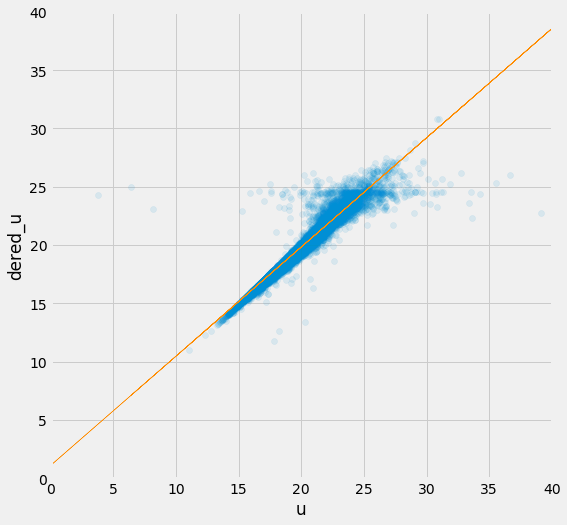

In [13]:
plt.figure(figsize=(8,8))
plt.scatter(X, y, alpha= .1)
plt.plot(X, theta0 + theta1 * x, color='darkorange', linewidth = .5)
plt.xlim(0, 40)
plt.ylim(0, 40)
plt.xlabel('u')
plt.ylabel('dered_u')


In [14]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X,y)
p = lr.predict(X)

In [15]:
rmse(y, p)

0.2522450693360897

In [16]:
lr.coef_, lr.intercept_

(array([0.9320425]), 1.1556424178625164)

Text(0, 0.5, 'dered_u')

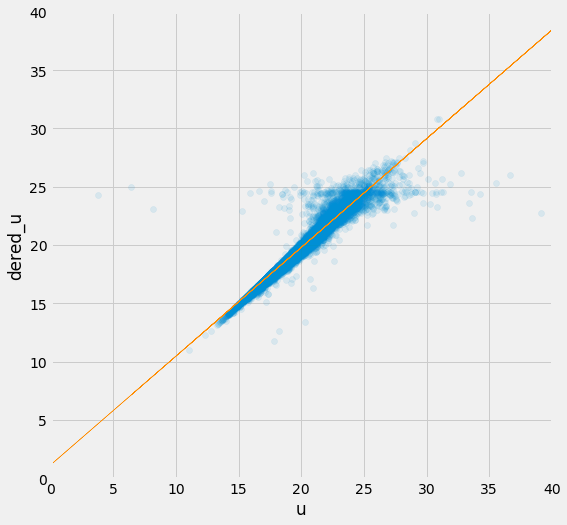

In [17]:
plt.figure(figsize=(8, 8))
plt.scatter(X, y, alpha=.1)
plt.plot(X, p, color='darkorange', linewidth=.5)
plt.xlim(0, 40)
plt.ylim(0, 40)
plt.xlabel('u')
plt.ylabel('dered_u')

In [18]:
X = trn[trn['class'] != 0].drop('class', axis=1)
y = trn[trn['class'] != 0]['class'].values - 1

np.unique(y)

array([0, 1], dtype=int64)

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score

lr = LogisticRegression()
lr.fit(X, y)
p = lr.predict_proba(X)[:, 1]

In [20]:
lr.coef_, lr.intercept_

(array([[ 0.7804547 ,  0.07861814, -1.88475231,  0.51044891, -0.57566255,
         -1.64446687,  2.28455202, -0.04729918, -1.35469458,  0.61598611,
         -0.58770508,  0.08588801, -0.10300867, -0.15121295, -0.15391136,
         -0.14866444, -0.14992119, -0.15254427]]),
 array([0.22407808]))

In [21]:
log_loss(y, p)

0.36560746044230846

In [22]:
roc_auc_score(y, p)

0.8762181520688405

In [26]:
from kaggler.metrics import plot_roc_curve, plot_pr_curve

Text(0.5, 1.0, 'Precision-Recall Curve')

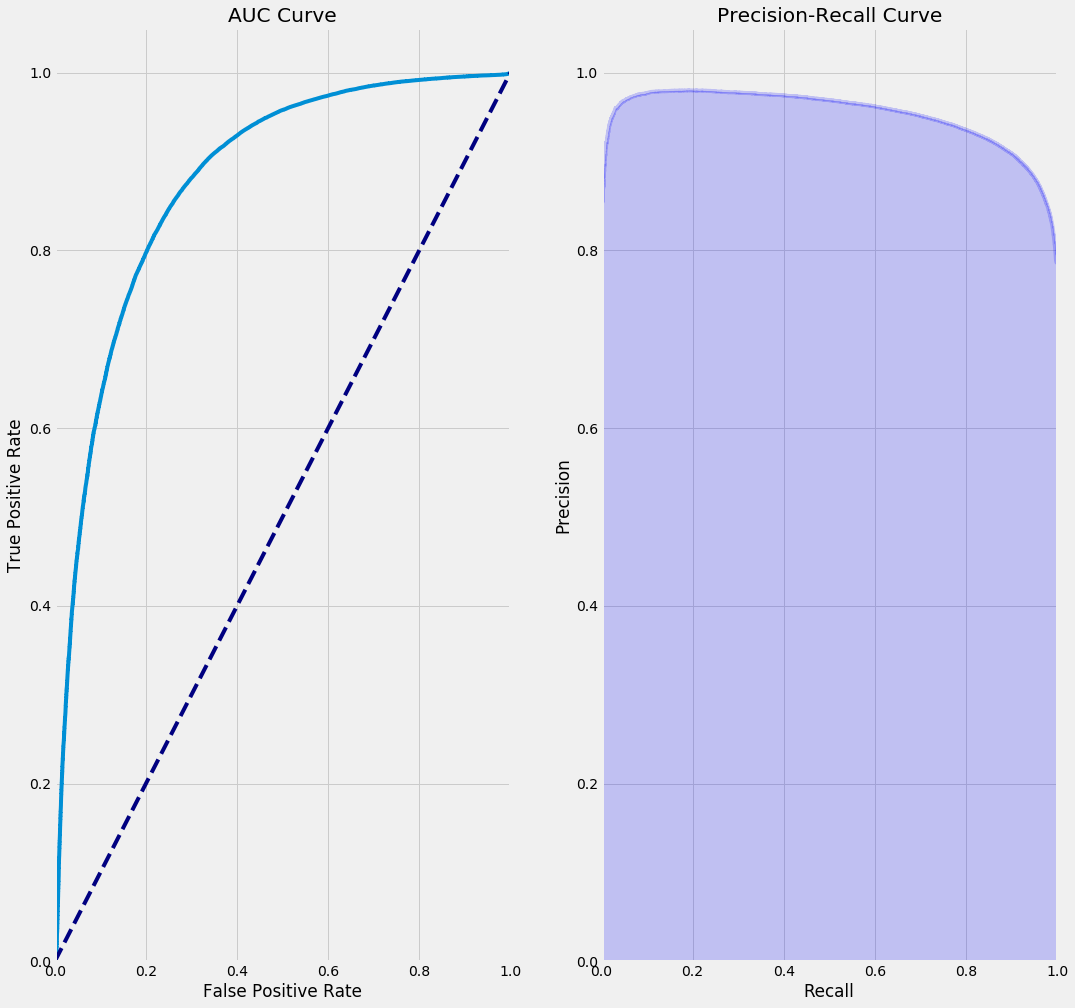

In [27]:
plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plot_roc_curve(y, p);
plt.title('AUC Curve')
plt.subplot(1, 2, 2)
plot_pr_curve(y, p);
plt.title('Precision-Recall Curve')